In [1]:
# import python libraries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import numpy as np
import pandas as pd
from textblob import TextBlob
import string
import matplotlib.pyplot as plt 
import networkx as nx
from PIL import Image
import seaborn as sns
from collections import Counter
import pprint
import itertools
%matplotlib inline

In [2]:
# load the text of The Little Prince
file = open('the_little_prince_text.txt', 'r') 
lp_txt = file.read()
file.close()

In [3]:
# Clean unrelated strings
lp_txt = lp_txt.replace("\n", " ") 
lp_txt = lp_txt.replace("_", "") 

In [4]:
# import nltk stop words list
sw = stopwords.words("english")
len(sw)  # 179 stop words

179

In [5]:
# open an image of little prince into an array
lp_image = np.array(Image.open("/Users/jasmine/Desktop/lp_2.png"))
lp_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
# transform the format of the image
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
# Transform the mask into a new one that will work with the function:
transformed_lp_image = np.ndarray((lp_image.shape[0],lp_image.shape[1]), np.int32)
for i in range(len(lp_image)):
    transformed_lp_image[i] = list(map(transform_format, lp_image[i]))
transformed_lp_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

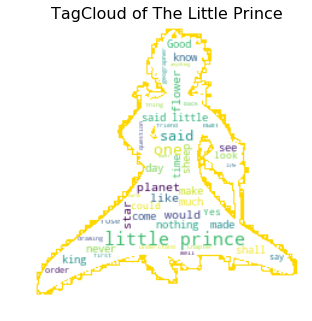

In [7]:
# generate the TagCloud
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_lp_image,
               stopwords=sw, contour_width=1, contour_color='gold')

wc.generate(lp_txt)

# display the TagCloud
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("TagCloud of The Little Prince",fontsize = 16)
plt.savefig("TagCloud of The Little Prince.png")

In [8]:
# create a new dataframe lp; tokenize the text into sentences; create a new column called sentence
lp = pd.DataFrame()
sent_count = sent_tokenize(lp_txt)
lp['sentence'] = sent_count

In [9]:
# first 5 rows
lp.head()

,sentence
0,﻿Chapter 1 Once when I was six years old I sa...
1,It was a picture of a boa constrictor in the a...
2,Here is a copy of the drawing.
3,"In the book it said:""Boa constrictors swallow ..."
4,"After that they are not able to move, and they..."


In [10]:
# number of sentences in the text
len(lp)

1450

In [11]:
# create a column called chap，indicating the chapter where the sentence locates
count = 0
chaps = []
for s in lp['sentence']:
    if 'Chapter' in s:
        count += 1
    chaps.append(count)
lp['chap'] = chaps

In [12]:
# number of sentence per chapter
num_sentence_chap = lp.groupby(['chap']).count()

In [13]:
# tokenize each sentence into words; create a column named word_token
def word_token(s):
    wt = word_tokenize(s)
    return wt
lp['word_token'] = lp['sentence'].apply(word_token)

In [14]:
# first 5 rows
lp.head()

,sentence,chap,word_token
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ..."
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,..."
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing, .]"
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, :, '', Boa, constric..."
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ..."


In [15]:
# create a column called sent_seq，indicating the position of each sentence in its chapter
lp['sent_seq'] = lp.groupby('chap')['sentence'].cumcount()
lp['sent_seq'] = lp['sent_seq']+1

In [16]:
# create a column named word_clean，removing punctuation marks
puncs = string.punctuation
def remo_punc(w):
    for p in w:
        if p in puncs:
            w.remove(p)
    return w
lp['word_clean'] = lp['word_token'].apply(remo_punc)

In [17]:
# first 5 rows
lp.head()

,sentence,chap,word_token,sent_seq,word_clean
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ..."
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,..."
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]"
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor..."
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ..."


In [18]:
# create a column named length_sent, calculating the length of a sentence
def length_sent(s):
    return len(s)
lp['length'] = lp['word_clean'].apply(length_sent)

In [19]:
# first 5 rows
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21


In [20]:
# create a dataframe from columns chap, length and sent_seq
lp_chap_leng = lp[['chap','length','sent_seq']]

In [21]:
# first 5 rows
lp_chap_leng.head()

,chap,length,sent_seq
0,1,26,1
1,1,15,2
2,1,7,3
3,1,15,4
4,1,21,5


In [22]:
# transfer lp_chap_leng into a new dataframe, chap_length，listing lengths of sentences as column
chap_length = lp_chap_leng.pivot(index='sent_seq', columns='chap', values='length').reset_index()

In [23]:
# first 5 rows
chap_length.head()

chap,sent_seq,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,26.0,32.0,14.0,50.0,25.0,24.0,29.0,10.0,33.0,...,14.0,11.0,51.0,9.0,10.0,10.0,39.0,28.0,29.0,11.0
1,2,15.0,6.0,18.0,8.0,15.0,34.0,41.0,13.0,13.0,...,14.0,17.0,9.0,7.0,8.0,7.0,54.0,41.0,29.0,7.0
2,3,7.0,22.0,16.0,49.0,18.0,24.0,15.0,20.0,7.0,...,8.0,9.0,6.0,17.0,7.0,14.0,13.0,12.0,11.0,15.0
3,4,15.0,20.0,33.0,18.0,12.0,10.0,7.0,17.0,17.0,...,7.0,46.0,10.0,15.0,4.0,18.0,20.0,9.0,7.0,12.0
4,5,21.0,18.0,6.0,10.0,29.0,8.0,8.0,41.0,8.0,...,6.0,7.0,7.0,5.0,14.0,7.0,4.0,25.0,14.0,7.0


In [24]:
# transpose chap_length, turning chap number into column names
chap_length = chap_length.T.reset_index()

In [25]:
# first 5 rows
chap_length.head()

,chap,0,1,2,3,4,5,6,7,8,...,125,126,127,128,129,130,131,132,133,134
0,sent_seq,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,126.0,127.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0
1,1,26.0,15.0,7.0,15.0,21.0,10.0,15.0,4.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,32.0,6.0,22.0,20.0,18.0,17.0,17.0,12.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,14.0,18.0,16.0,33.0,6.0,2.0,4.0,5.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,50.0,8.0,49.0,18.0,10.0,21.0,10.0,8.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# remove the row starting with sent_seq
chap_length = chap_length.drop([0],axis = 0)

In [27]:
# add 1 to each numeric column name
new_col = []
for i in chap_length.columns:
    if i != 'chap':
        i += 1
        new_col.append(i)
    else:        
        new_col.append(i)
chap_length.columns = new_col

In [28]:
# first 5 rows
chap_length.head()

,chap,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
1,1,26.0,15.0,7.0,15.0,21.0,10.0,15.0,4.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,32.0,6.0,22.0,20.0,18.0,17.0,17.0,12.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,14.0,18.0,16.0,33.0,6.0,2.0,4.0,5.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,50.0,8.0,49.0,18.0,10.0,21.0,10.0,8.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,25.0,15.0,18.0,12.0,29.0,6.0,2.0,4.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# fill all the null cells with value 0
chap_length = chap_length.fillna(0)

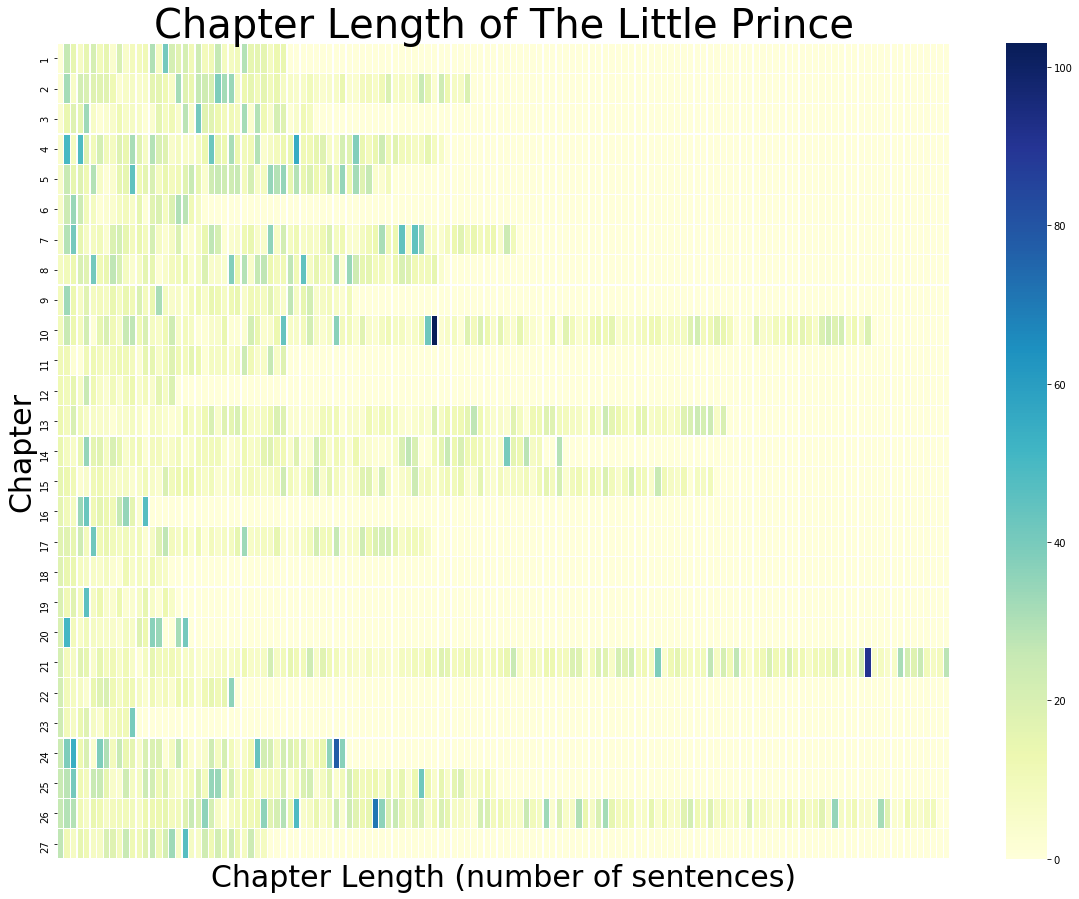

In [30]:
# plot the diagram
plt.figure(figsize=(20,15))
ax = sns.heatmap(chap_length,square = False,xticklabels = False,yticklabels = True,\
                 cbar = True,linewidths = 0.25,cmap="YlGnBu")
#ax.set(xlabel='Chapter Length (number of sentences)', ylabel='Chapter')
ax.set_xlabel("Chapter Length (number of sentences)",fontsize=30)
ax.set_ylabel("Chapter",fontsize=30)
plt.title("Chapter Length of The Little Prince", fontsize = 40)
plt.savefig("Chapter Length of The Little Prince.png")

In [31]:
# first 5 rows
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21


In [32]:
# create a column sentiment
def sentiment_get(s):
    senti = TextBlob(s)
    return senti.sentiment.polarity
lp['sentiment'] = lp['sentence'].apply(sentiment_get)
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length,sentiment
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26,0.483333
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15,0.000000
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7,0.000000
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15,0.200000
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21,-0.250000


In [33]:
# create a column sent_seq_pass，indicating the position of each sentence in the whole text
lp['sent_seq_pass'] = lp.index
lp['sent_seq_pass'] = lp['sent_seq_pass']+1
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length,sentiment,sent_seq_pass
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26,0.483333,1
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15,0.000000,2
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7,0.000000,3
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15,0.200000,4
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21,-0.250000,5


In [34]:
# find nouns in the text; label them in new columns with 1 for existence and 0 for non-existence
sths = ['prince','rose','flower','fox','sheep','lamplighter']
def find_something(s):
    if th in s:
        return 1
    else:
        return 0
for th in sths:
    lp[th] = lp['sentence'].apply(find_something)

In [35]:
# first 5 rows
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length,sentiment,sent_seq_pass,prince,rose,flower,fox,sheep,lamplighter
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26,0.483333,1,0,0,0,0,0,0
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15,0.000000,2,0,0,0,0,0,0
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7,0.000000,3,0,0,0,0,0,0
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15,0.200000,4,0,0,0,0,0,0
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21,-0.250000,5,0,0,0,0,0,0


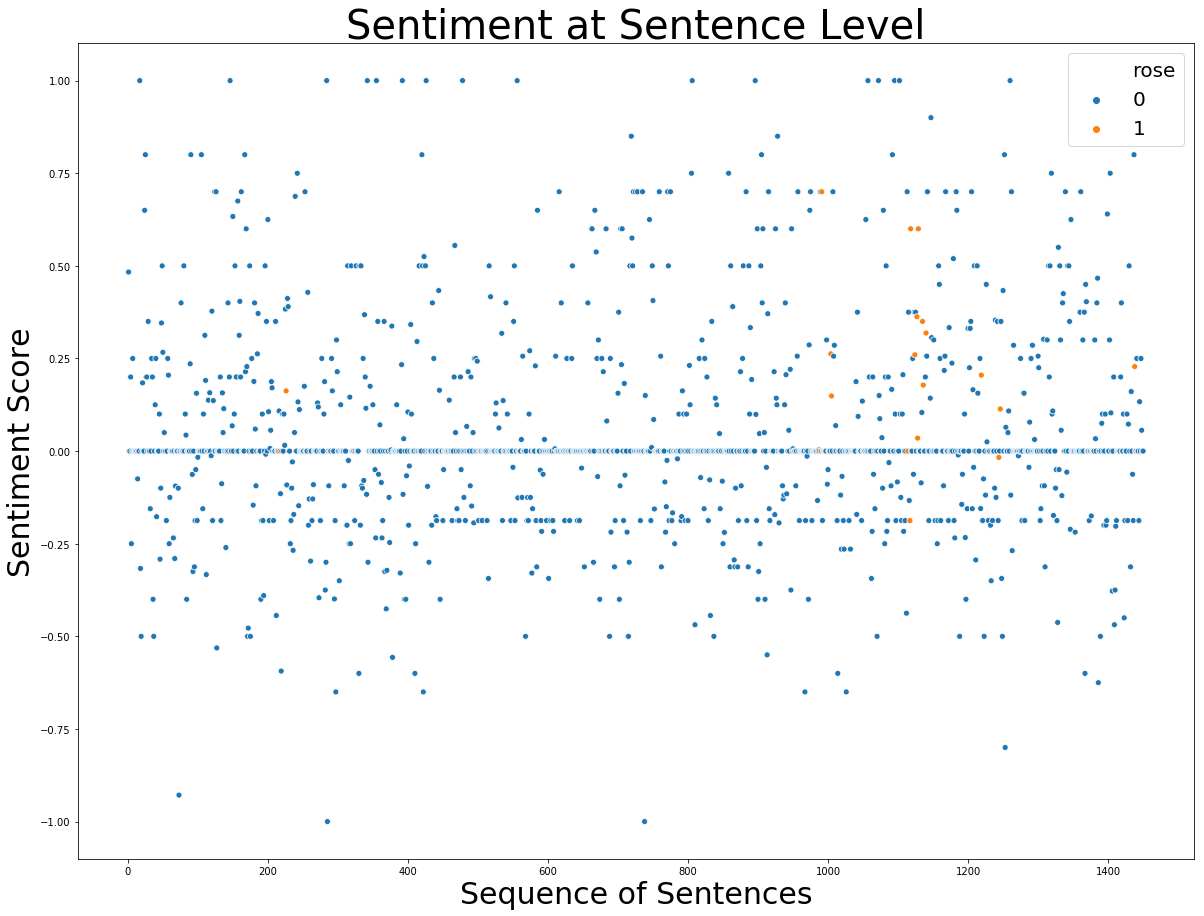

In [36]:
# plot the sentiment score and color sentences in orange which contains the word rose
plt.figure(figsize=(20,15))
ax = sns.scatterplot(x="sent_seq_pass", y="sentiment", hue = 'rose',data=lp, alpha=1)
ax.set_xlabel('Sequence of Sentences',fontsize=30)
ax.set_ylabel('Sentiment Score',fontsize=30)
ax.set_title('Sentiment at Sentence Level',fontsize=40)
ax.legend(loc='upper right', fontsize=20)
plt.savefig("Sentiment of The Little Prince.png")

In [37]:
# create a column tagging, listing part of speech of words in each sentence 
def tagging(s):
    tagged_text = pos_tag(s)
    return tagged_text
lp['tagging'] = lp['word_token'].apply(tagging)

In [38]:
# first 5 rows
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length,sentiment,sent_seq_pass,prince,rose,flower,fox,sheep,lamplighter,tagging
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26,0.483333,1,0,0,0,0,0,0,"[(﻿Chapter, RB), (1, CD), (Once, RB), (when, W..."
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15,0.000000,2,0,0,0,0,0,0,"[(It, PRP), (was, VBD), (a, DT), (picture, NN)..."
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7,0.000000,3,0,0,0,0,0,0,"[(Here, RB), (is, VBZ), (a, DT), (copy, NN), (..."
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15,0.200000,4,0,0,0,0,0,0,"[(In, IN), (the, DT), (book, NN), (it, PRP), (..."
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21,-0.250000,5,0,0,0,0,0,0,"[(After, IN), (that, DT), (they, PRP), (are, V..."


In [39]:
# create a column find_nouns, extracting nouns in taggings
def find_nouns(tagged_text):
    nouns = []
    i = 0
    for i in range(len(tagged_text)):
        if 'NN' in tagged_text[i][1]:
            nouns.append(tagged_text[i][0].lower())
    return nouns
lp['find_nouns'] = lp['tagging'].apply(find_nouns)

In [40]:
# first 5 rows
lp.head()

,sentence,chap,word_token,sent_seq,word_clean,length,sentiment,sent_seq_pass,prince,rose,flower,fox,sheep,lamplighter,tagging,find_nouns
0,﻿Chapter 1 Once when I was six years old I sa...,1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",1,"[﻿Chapter, 1, Once, when, I, was, six, years, ...",26,0.483333,1,0,0,0,0,0,0,"[(﻿Chapter, RB), (1, CD), (Once, RB), (when, W...","[years, picture, book, true, stories, nature, ..."
1,It was a picture of a boa constrictor in the a...,1,"[It, was, a, picture, of, a, boa, constrictor,...",2,"[It, was, a, picture, of, a, boa, constrictor,...",15,0.000000,2,0,0,0,0,0,0,"[(It, PRP), (was, VBD), (a, DT), (picture, NN)...","[picture, boa, constrictor, act, animal]"
2,Here is a copy of the drawing.,1,"[Here, is, a, copy, of, the, drawing]",3,"[Here, is, a, copy, of, the, drawing]",7,0.000000,3,0,0,0,0,0,0,"[(Here, RB), (is, VBZ), (a, DT), (copy, NN), (...","[copy, drawing]"
3,"In the book it said:""Boa constrictors swallow ...",1,"[In, the, book, it, said, '', Boa, constrictor...",4,"[In, the, book, it, said, '', Boa, constrictor...",15,0.200000,4,0,0,0,0,0,0,"[(In, IN), (the, DT), (book, NN), (it, PRP), (...","[book, boa, constrictors]"
4,"After that they are not able to move, and they...",1,"[After, that, they, are, not, able, to, move, ...",5,"[After, that, they, are, not, able, to, move, ...",21,-0.250000,5,0,0,0,0,0,0,"[(After, IN), (that, DT), (they, PRP), (are, V...","[months, digestion]"


In [41]:
# create a dictionary nn_dict，counting frequency of each noun
nn_list = []
def nn_num(s):
    for i in s:
        nn_list.append(i)
lp['find_nouns'].apply(nn_num)  
nn_dict = Counter(nn_list)

In [42]:
# create a dataframe noun_count，columns noun, count, perc（percentage）；sumperc（cumulative percentage）
noun_count = pd.DataFrame.from_dict(nn_dict, orient='index').sort_values(by=[0],ascending = False)
noun_count.reset_index(level=0, inplace=True)
noun_count = noun_count.rename(columns={0: "count","index":'noun'})
noun_count['perc'] = noun_count['count']/ noun_count['count'].sum()
noun_count['sumperc'] = noun_count['perc'].cumsum()
noun_count.head(10)

,noun,count,perc,sumperc
0,prince,185,0.061914,0.061914
1,planet,69,0.023092,0.085007
2,flower,54,0.018072,0.103079
3,time,46,0.015395,0.118474
4,stars,41,0.013722,0.132195
5,sheep,37,0.012383,0.144578
6,fox,35,0.011714,0.156292
7,man,34,0.011379,0.167671
8,day,32,0.010710,0.178380
9,nothing,31,0.010375,0.188755


In [43]:
# the shape of noun_count
noun_count.shape

(940, 4)

In [44]:
# create a new dataframe lp_nouns，from column nouns in lp
lp_nouns = lp[['find_nouns']]

In [45]:
# create a column num_noun，indicating the number of nouns in each sentence
def num_noun(s):
    return len(s)
lp_nouns['num_noun'] = lp['find_nouns'].apply(num_noun)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [46]:
# first 5 rows
lp_nouns.head()

,find_nouns,num_noun
0,"[years, picture, book, true, stories, nature, ...",8
1,"[picture, boa, constrictor, act, animal]",5
2,"[copy, drawing]",2
3,"[book, boa, constrictors]",3
4,"[months, digestion]",2


In [47]:
# number of total pairs in find_nouns
def num_rela(s):
    return (s-1)*s/2
lp_nouns['num_rela'] = lp_nouns['num_noun'].apply(num_rela)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [48]:
# first five rows
lp_nouns.head()

,find_nouns,num_noun,num_rela
0,"[years, picture, book, true, stories, nature, ...",8,28.0
1,"[picture, boa, constrictor, act, animal]",5,10.0
2,"[copy, drawing]",2,1.0
3,"[book, boa, constrictors]",3,3.0
4,"[months, digestion]",2,1.0


In [49]:
# make every two nouns in a sentence into a pair
pairs_noun =[]
def pairs(s):
    p = list(itertools.combinations(s, 2))
    for ps in p:
        pairs_noun.append(ps)
    return pairs_noun
lp_nouns['find_nouns'].apply(pairs)
print ("The number of noun pairs is" + " " +str(len(pairs_noun))+".")

The number of noun pairs is 4348.


In [50]:
# create a dataframe noun_pairs, with columns noun1 and noun2, indicating each element in noun pairs respectively
noun_pairs = pd.DataFrame()

noun1_list =[]
noun2_list =[]
for pair in pairs_noun:
    noun1_list.append(pair[0])
    noun2_list.append(pair[1])

noun_pairs['noun1'] = noun1_list
noun_pairs['noun2'] = noun2_list
noun_pairs.shape

(4348, 2)

In [51]:
# top ten nouns in The Little Prince
main_nouns = ['prince','planet','flower','time','stars',\
              'sheep','fox','king','geographer','grown-ups']

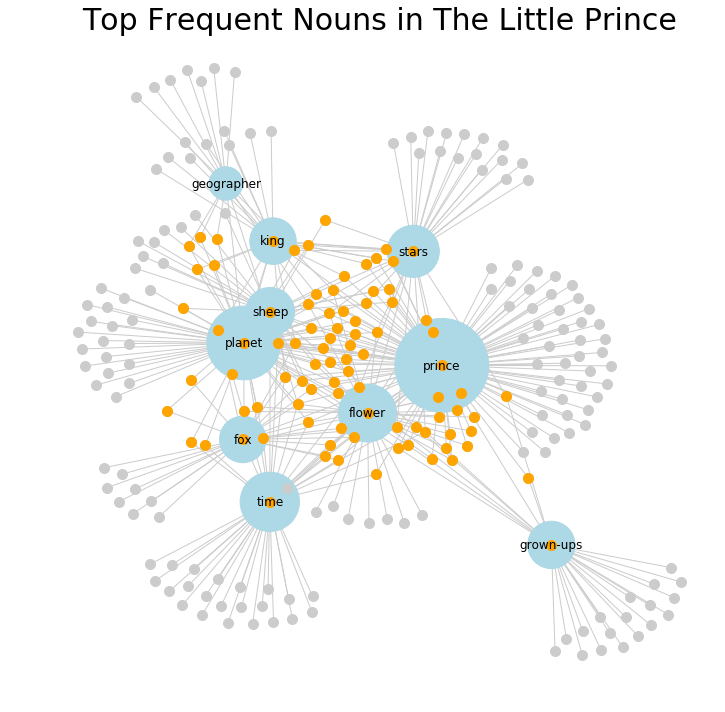

In [52]:
# plot the diagram
main_pairs = noun_pairs.loc[noun_pairs['noun2'].isin(main_nouns)]
main_pairs = noun_pairs.loc[noun_pairs['noun2'].isin(main_nouns)]
n2 = list(main_pairs.noun2.unique())
n1 = list(main_pairs.noun1.unique())

plt.figure(figsize=(12, 12))
g = nx.from_pandas_edgelist(main_pairs, source='noun1', target='noun2') 
layout = nx.spring_layout(g,iterations=50)
n2_size = [g.degree(n) * 80 for n in n2]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=n2, 
                       node_size=n2_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')
nx.draw_networkx_nodes(g, layout, nodelist=n1, node_color='#cccccc', node_size=100)
popular_n1 = [s for s in n1 if g.degree(s) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_n1, node_color='orange', node_size=100)
nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")
node_labels = dict(zip(n2, n2))
nx.draw_networkx_labels(g, layout, labels=node_labels)
plt.axis('off')
plt.title("Top Frequent Nouns in The Little Prince",fontsize = 30)
plt.savefig("Little Prince Main Nouns.png")
plt.show()